In [9]:
# Create candidates.tsv files for different number of neighbours
import subprocess
import itertools
import os
os.chdir("/private/home/marialomeli/LASER")
os.environ['LASER'] = "${HOME}/LASER"
powers_of_two = [2**p for p in range(1,8)]
for neigh in powers_of_two:
    command = ['python', 'source/mine_bitexts.py','/checkpoint/marialomeli/bucc_evaluation/bucc2018.de-en.train.txt.de','/checkpoint/marialomeli/bucc_evaluation/bucc2018.de-en.train.txt.en','--src-lang','de','--trg-lang','en','--src-embeddings','/private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.de-en.train.de', '--trg-embeddings','/private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.de-en.train.en','--mode','mine','--retrieval','max','--margin','distance','-k',str(neigh),'--output', '/private/home/marialomeli/LASER/tasks/bucc/embed','--code_size','16', '--verbose', '--fp16', '--unify']
    output = subprocess.check_output(command, universal_newlines=True)
    print(output)

2023-07-06 05:43:34,757 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
LASER: tool to search, score or mine bitexts
 - knn will run on CPU (slow)
 - loading texts /checkpoint/marialomeli/bucc_evaluation/bucc2018.de-en.train.txt.de: 413869 lines, 412909 unique
 - loading texts /checkpoint/marialomeli/bucc_evaluation/bucc2018.de-en.train.txt.en: 399337 lines, 397151 unique
 - Embeddings: /private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.de-en.train.de, 413869x1024
 - unify embeddings: 413869 -> 412909
 - Embeddings: /private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.de-en.train.en, 399337x1024
 - unify embeddings: 399337 -> 397151
loading bigger file and adjusting size to 2:
 - mining for parallel data
 - scoring 412909 candidates
 - scoring 412909 candidates
 - writing alignments to /private/home/marialomeli/LASER/tasks/bucc/embed/sonar.margin_distance.retrieval_max.bucc2018.de-en.PQ16.trai

In [15]:

# load candidate.tsv files and compute precision and recall
# can run bucc.py with the given file name and collect the output
# we don't need to run for all values of k, we can reuse one of the files 
# with lots of neighbours and select a subset 
powers_of_two = [2**p for p in range(1,8)]+[200]
powers_of_two = [2]
code_sizes = [512,256,128,64,32]
files = {}
flat =[f"sonar.k{neigh}.bucc2018.de-en.train.candidates.tsv" for neigh in powers_of_two]
flat_diff=[f"sonar_difference.k{neigh}.bucc2018.de-en.train.candidates.tsv" for neigh in powers_of_two]
flat_abs = [f"sonar.margin_absolute.retrieval_max.bucc2018.de-en.train.k{neigh}.candidates.tsv" for neigh in powers_of_two]
sq8=[f"sonar.margin_absolute.retrieval_max.bucc2018.de-en.SQ8.train.k{neigh}.candidates.tsv" for neigh in powers_of_two]
#files["flat"]=flat
#files["flat"]=flat_diff
files["flat"]=flat_abs
#files["sq8"]=sq8
for code_size in code_sizes:
    pq_ratio = [f"sonar.margin_ratio.retrieval_max.bucc2018.de-en.PQ{code_size}.train.k{neigh}.candidates.tsv" for neigh in powers_of_two]
#    pq_distance = [f"sonar.margin_distance.retrieval_max.bucc2018.de-en.PQ{code_size}.train.k{neigh}.candidates.tsv" for neigh in powers_of_two]
    pq_absolute = [f"sonar.margin_absolute.retrieval_max.bucc2018.de-en.PQ{code_size}.train.k{neigh}.candidates.tsv" for neigh in powers_of_two]
#    files[f"pq{code_size}"]=pq_ratio
   # files[f"pq{code_size}"]=pq_distance
    #files[f"pq{code_size}"]=pq_absolute

print(files)


{'flat': ['sonar.margin_absolute.retrieval_max.bucc2018.de-en.train.k2.candidates.tsv']}


In [16]:
import subprocess
import itertools
import os
os.chdir("/private/home/marialomeli/LASER/tasks/bucc")
thresholds = {}
precisions= {}
recalls = {}
F1 =  {}
results_directory="/private/home/marialomeli/LASER/tasks/bucc/embed/"
print(files.keys())
for index_string in files.keys():
    thresholds[index_string]=[]
    precisions[index_string]=[]
    recalls[index_string]=[]
    F1[index_string]=[]
    for filename in files[index_string]:
        assert os.path.exists(results_directory+filename), f"file does not exist {results_directory+filename}"
        command = ['python', 'bucc.py','--src-lang','de','--trg-lang','en','--bucc-texts','/checkpoint/marialomeli/bucc_evaluation/bucc2018.de-en.train.txt','--bucc-ids','/checkpoint/marialomeli/bucc_evaluation/bucc2018.de-en.train.id','--candidates','./embed/'+filename,'--gold','./bucc2018/de-en/de-en.training.gold','--verbose']
        output = subprocess.check_output(command, universal_newlines=True)
        print(filename)
        print(output)
        allbits=output.split('\n')
        helper = [bit.split(',') for bit in allbits[9].split('=')]
        all_metrics = list(itertools.chain.from_iterable(helper))
        thresholds[index_string].append(float(all_metrics[1]))
        precisions[index_string].append(float(all_metrics[3]))
        recalls[index_string].append(float(all_metrics[5]))
        F1[index_string].append(float(all_metrics[7]))

print(thresholds,recalls,precisions,F1)


dict_keys(['flat'])
sonar.margin_absolute.retrieval_max.bucc2018.de-en.train.k2.candidates.tsv
LASER: tools for BUCC bitext mining
 - reading sentences and IDs
 - reading candidates ./embed/sonar.margin_absolute.retrieval_max.bucc2018.de-en.train.k2.candidates.tsv
precisions will be saved in file: ./embed/PR/sonar.margin_absolute.retrieval_max.bucc2018.de-en.train.k2.candidates.precisions
recalls will be saved in file: ./embed/PR/sonar.margin_absolute.retrieval_max.bucc2018.de-en.train.k2.candidates.recalls
thresholds will be saved in file: ./embed/PR/sonar.margin_absolute.retrieval_max.bucc2018.de-en.train.k2.candidates.thresholds
 - optimizing threshold on gold alignments ./bucc2018/de-en/de-en.training.gold
len of candidates: 218170
length of items: 218170
 - best threshold=0.662772, precision=93.22, recall=89.86, F1=91.51



In [19]:

allbits=output.split('\n')
allbits[9]

' - best threshold=0.662772, precision=93.22, recall=89.86, F1=91.51'

flat
pq512
pq256
pq128
pq64
pq32


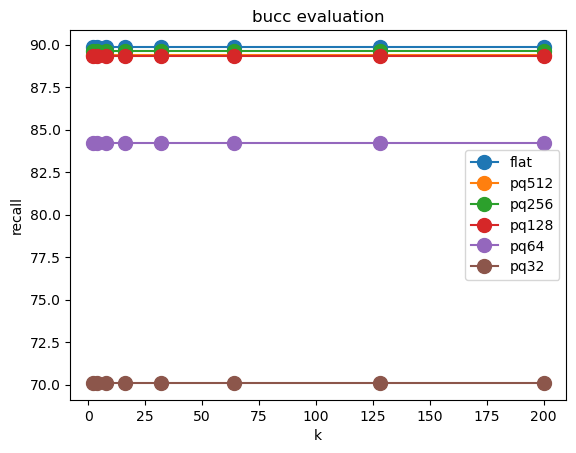

In [37]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]+[200]
colors = ["g", "b", "r", "m", "y", "c",'k'] 
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two, recalls[file], "o-", markersize=10, color=colors[i], label=file)

    #plt.plot(powers_of_two,recalls["ratio"], "o-", markersize=10, color=colors[2],label=index_strings[0])
#plt.xscale("log")

plt.xlabel("k")
plt.ylabel("recall")
plt.savefig("recall_margin_ratio.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

flat
pq512
pq256
pq128
pq64
pq32


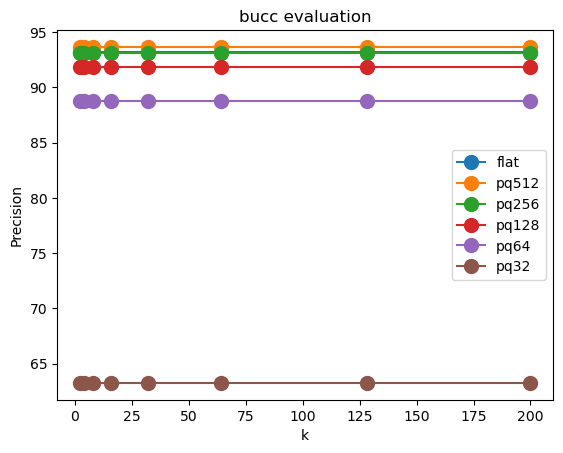

In [38]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]+[200]
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two,precisions[file], "o-", markersize=10, color=colors[i],label=file)
#plt.xscale("log")

plt.xlabel("k")
plt.ylabel("Precision")
plt.savefig("precision_margin_ratio.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

flat
pq512
pq256
pq128
pq64
pq32


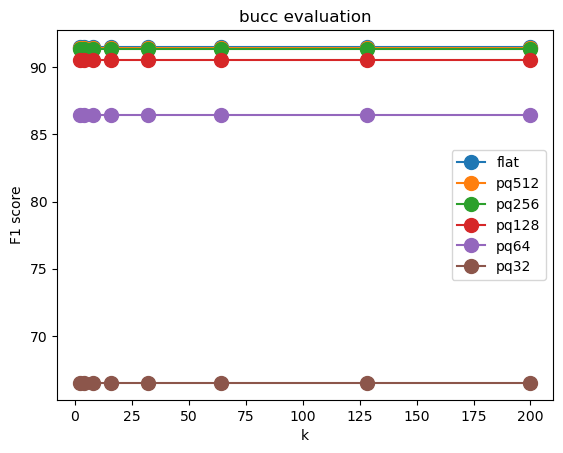

In [39]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]+[200]
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two,F1[file], "o-", markersize=10, color=colors[i],label=file)

#plt.xscale("log")

plt.xlabel("k")
plt.ylabel("F1 score")
plt.savefig("F1_score_margin_ratio.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

flat
pq512
pq256
pq128
pq64
pq32


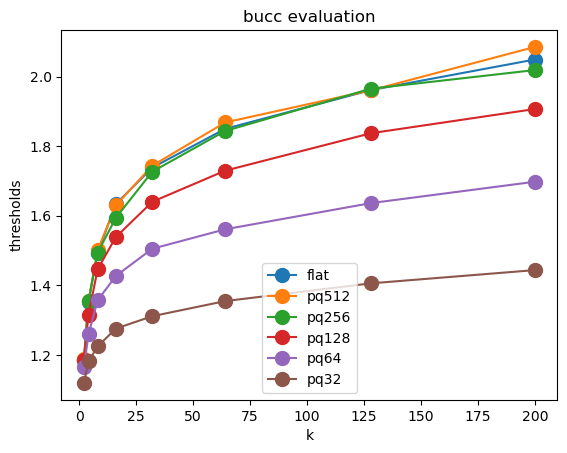

In [31]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]+[200]
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']


for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two, thresholds[file], "o-", markersize=10, color=colors[i], label=file)
#plt.xscale("log")
plt.xlabel("k")
plt.ylabel("thresholds")
plt.savefig("lthresholds_margin_ratio.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

In [2]:
import numpy as np
def EmbedLoad(fname, dim=1024, verbose=False, fp16=False):
    x = np.fromfile(fname, dtype=(np.float16 if fp16 else np.float32), count=-1)
    x.resize(x.shape[0] // dim, dim)
    if verbose:
        print(" - Embeddings: {:s}, {:d}x{:d}".format(fname, x.shape[0], dim))
    return x


In [4]:
import faiss
import glob
common_dir = "/private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/*.train.*" #SONAR embeddings
#common_dir = "/checkpoint/marialomeli/bucc_evaluation/*.train.enc.*" #LASER embeddings 
for file in  glob.iglob(common_dir):
    print("Matrix stats for:",
          file)
    x = EmbedLoad(file,fp16=True)
    print(faiss.MatrixStats(x).comments)

Matrix stats for: /private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.de-en.train.de
analyzing 413869 vectors of size 1024
no NaN or Infs in data
412932 vectors are distinct (99.77%)
vector 1178 has 37 copies
range of L2 norms=[0.129181, 0.389608] (0 null vectors)
matrix contains 0.00 % 0 entries
no constant dimensions
no dimension has a too large mean
stddevs per dimension are in [6.1706e-05 0.014338]

Matrix stats for: /private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.de-en.train.en
analyzing 399337 vectors of size 1024
no NaN or Infs in data
397246 vectors are distinct (99.48%)
vector 356131 has 8 copies
range of L2 norms=[0.125195, 0.381765] (0 null vectors)
matrix contains 0.00 % 0 entries
no constant dimensions
no dimension has a too large mean
stddevs per dimension are in [4.98589e-05 0.0141463]

Matrix stats for: /private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.fr-en.train.en
analyzing 369810 vectors o

In [7]:
import numpy as np
from faiss.contrib.evaluation import knn_intersection_measure
common_dir = "/private/home/marialomeli/LASER/tasks/bucc/embed/sim_and_ind/"
x2y_flat = np.load(common_dir+"de-en.x2y_ind.npy") 

powers_of_two = [2**p for p in range(1,8)]+[200]
knn_im={}
knn_im["SQ_8"]=[]
x2y_sq = np.load(common_dir+"de-en.SQ8.x2y_ind.npy") 
for k in powers_of_two:
        knn_im["SQ_8"].append(knn_intersection_measure(x2y_flat[:,:k], x2y_sq[:,:k]))
code_sizes = [16,32,64,128,256,512]
for code_size in code_sizes:
    knn_im["PQ_"+str(code_size)]=[]
    x2y_pq = np.load(common_dir+f"de-en.PQ{code_size}.x2y_ind.npy") 
    for k in powers_of_two:
        knn_im["PQ_"+str(code_size)].append(knn_intersection_measure(x2y_flat[:,:k], x2y_pq[:,:k]))

x2y_sq = np.load(common_dir+"de-en.SQ8.x2y_ind.npy") 

knn_im


{'SQ_8': [0.9898476419743818,
  0.9896744803334391,
  0.9898458255935327,
  0.9901437120527767,
  0.9904445501309005,
  0.9910312411451434,
  0.9916162482229741,
  0.9919224453814278],
 'PQ_16': [0.08302434676890065,
  0.09039824755575684,
  0.10110611539104258,
  0.11428971032358219,
  0.1304316598814751,
  0.14953737536600073,
  0.1716532312507114,
  0.18744463065711817],
 'PQ_32': [0.19974255828766144,
  0.21232160112760923,
  0.2233639857692615,
  0.2349051183190485,
  0.24662932692191258,
  0.2600897307275937,
  0.2756215276852769,
  0.2866378548299989],
 'PQ_64': [0.37125129265770423,
  0.38708165721744986,
  0.3975533955423592,
  0.4049368323286729,
  0.41087836545098316,
  0.41702382516486686,
  0.4240487727017333,
  0.4293699095926705],
 'PQ_128': [0.55005097975583,
  0.5672363644289662,
  0.578467955409061,
  0.5841073638501462,
  0.586894600263012,
  0.5889059393231922,
  0.5909393020011673,
  0.5926825281115209],
 'PQ_256': [0.7309225519424377,
  0.7448124162951159,
  0.755

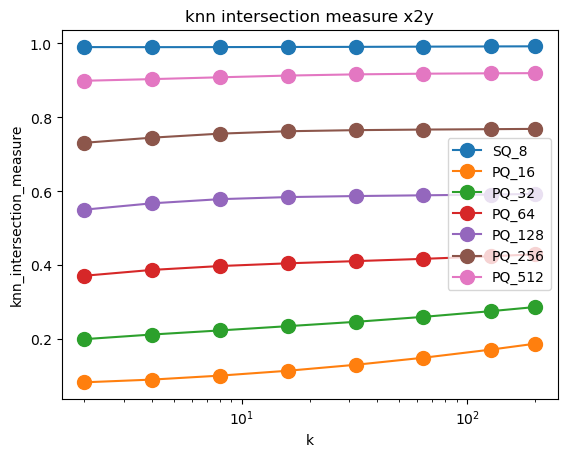

In [8]:
import numpy as np
import matplotlib.pyplot as plt
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
powers_of_two = [2**p for p in range(1,8)]+[200]
ell=0
for i, knn in knn_im.items():
    plt.plot(powers_of_two, knn, "o-", markersize=10, color=colors[ell], label=i)
    ell+=1
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("knn_intersection_measure")
plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("knn intersection measure x2y")
plt.legend()
plt.show()

In [9]:
import numpy as np
from faiss.contrib.evaluation import knn_intersection_measure
common_dir = "/private/home/marialomeli/LASER/tasks/bucc/embed/sim_and_ind/"
y2x_flat = np.load(common_dir+"de-en.y2x_ind.npy") 

powers_of_two = [2**p for p in range(1,8)]+[200]
knn_im={}
knn_im["SQ_8"]=[]
x2y_sq = np.load(common_dir+"de-en.SQ8.x2y_ind.npy") 
for k in powers_of_two:
        knn_im["SQ_8"].append(knn_intersection_measure(x2y_flat[:,:k], x2y_sq[:,:k]))
code_sizes = [16,32,64,128,256,512]
for code_size in code_sizes:
    knn_im["PQ_"+str(code_size)]=[]
    y2x_pq = np.load(common_dir+f"de-en.PQ{code_size}.y2x_ind.npy") 
    for k in powers_of_two:
        knn_im["PQ_"+str(code_size)].append(knn_intersection_measure(y2x_flat[:,:k], y2x_pq[:,:k]))

knn_im

{'SQ_8': [0.9898476419743818,
  0.9896744803334391,
  0.9898458255935327,
  0.9901437120527767,
  0.9904445501309005,
  0.9910312411451434,
  0.9916162482229741,
  0.9919224453814278],
 'PQ_16': [0.08379558404737744,
  0.0897517568884379,
  0.0988056180143069,
  0.11027370571898346,
  0.12425516365311934,
  0.14140858892461558,
  0.16141833490284552,
  0.17580857155087107],
 'PQ_32': [0.2003230509302507,
  0.21042626104428794,
  0.21978258899008185,
  0.22899869948709684,
  0.2391884635818618,
  0.2506925105312589,
  0.2640392917303494,
  0.2738544533439422],
 'PQ_64': [0.36930663651860374,
  0.38384581683037433,
  0.39235108308930355,
  0.39715467164881874,
  0.4008813713172068,
  0.40476083876157937,
  0.4097936970132267,
  0.4139087148213148],
 'PQ_128': [0.5455305412802687,
  0.5614986491284172,
  0.5709320888024958,
  0.5743926743228646,
  0.5754875821790705,
  0.5755209054616506,
  0.5756674570881101,
  0.576399077428988],
 'PQ_256': [0.7331858663329565,
  0.745215925428867,
  0.

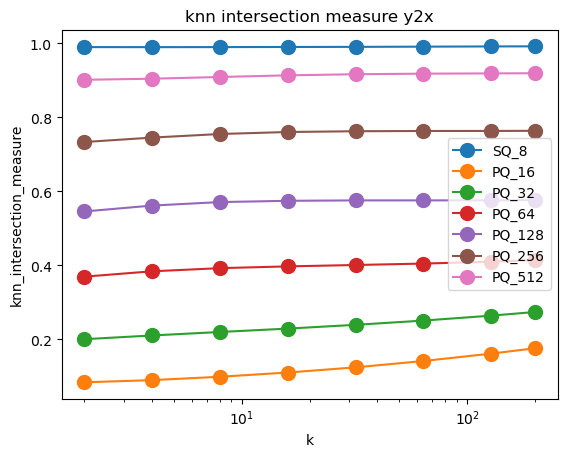

In [10]:
import numpy as np
import matplotlib.pyplot as plt
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
powers_of_two = [2**p for p in range(1,8)]+[200]
ell=0
for i, knn in knn_im.items():
    plt.plot(powers_of_two, knn, "o-", markersize=10, color=colors[ell], label=i)
    ell+=1
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("knn_intersection_measure")
plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("knn intersection measure y2x")
plt.legend()
plt.show()

In [16]:
#PR curve SONAR
import numpy as np
precisions_pq64=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.PQ64.train.k200.precisions")
recalls_pq64=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.PQ64.train.k200.recalls")
precisions_pq64_nr=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.PQ64.train.k200.precisions.no_repeats")
recalls_pq64_nr=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.PQ64.train.k200.recalls.no_repeats")
precisions_pq64_diff=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.PQ64.train.k200.precisions")
recalls_pq64_diff=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.PQ64.train.k200.recalls")
precisions_pq64_diff_nr=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.PQ64.train.k200.precisions.no_repeats")
recalls_pq64_diff_nr=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.PQ64.train.k200.recalls.no_repeats")
precisions_flat_nr =np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.train.k200.candidates.precisions.no_repeats")
recalls_flat_nr = np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.train.k200.candidates.recalls.no_repeats")
precisions_flat =np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.train.k200.candidates.precisions")
recalls_flat = np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.train.k200.candidates.recalls")
precisions_flat_diff_nr=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.train.k200.candidates.precisions.no_repeats")
recalls_flat_diff_nr  = np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.train.k200.candidates.recalls.no_repeats")
precisions_flat_diff =np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.train.k200.candidates.precisions")
recalls_flat_diff  = np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.train.k200.candidates.recalls")

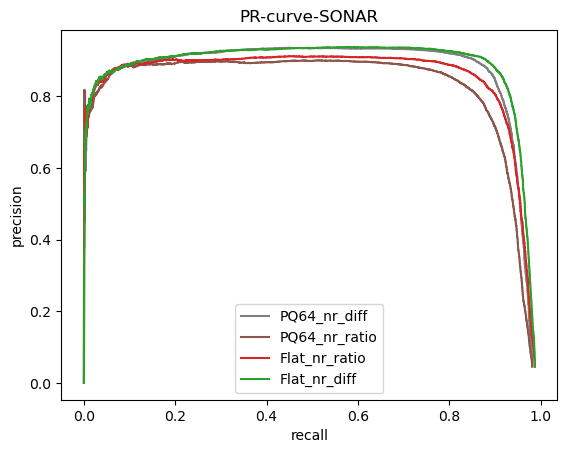

In [18]:
import matplotlib.pyplot as plt
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
#plt.plot(recalls_pq64_diff, precisions_pq64_diff, "-", markersize=10, color=colors[6],label="PQ64_diff")
plt.plot(recalls_pq64_diff_nr, precisions_pq64_diff_nr, "-", markersize=10, color=colors[7],label="PQ64_nr_diff")
#plt.plot(recalls_pq64, precisions_pq64, "-", markersize=10, color=colors[0],label="PQ64_ratio")
plt.plot(recalls_pq64_nr, precisions_pq64_nr, "-", markersize=10, color=colors[5],label="PQ64_nr_ratio")
#plt.plot(recalls_flat, precisions_flat, "-", markersize=10, color=colors[1],label="Flat_ratio")
plt.plot(recalls_flat_nr, precisions_flat_nr, "-", markersize=10, color=colors[3],label="Flat_nr_ratio")
plt.plot(recalls_flat_diff_nr, precisions_flat_diff_nr, "-", markersize=10, color=colors[2],label="Flat_nr_diff")
#plt.plot(recalls_flat_diff, precisions_flat_diff, "-", markersize=10, color=colors[4],label="Flat_diff")
plt.xlabel("recall")
plt.ylabel("precision")
#plt.xscale("log")
#plt.yscale("log")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("PR-curve-SONAR")
plt.legend()
plt.show()

In [ ]:
# SONAR average vs max in denominator , k=4
import numpy as np
precisions_flat_m =np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.train.k200.candidates.precisions.no_repeats.max_denominator")
recalls_flat_m = np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.train.k200.candidates.recalls.no_repeats.max_denominator")
precisions_flat_a =np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.train.k200.candidates.precisions.no_repeats")
recalls_flat_a = np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.train.k200.candidates.recalls.no_repeats")
precisions_flat_diff_m =np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.train.k200.candidates.precisions.no_repeats.max_denominator")
recalls_flat_dif_m  = np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.train.k200.candidates.recalls.no_repeats.max_denominator")
precisions_flat_diff_a =np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.train.k200.candidates.precisions.no_repeats")
recalls_flat_diff_a  = np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.train.k200.candidates.recalls.no_repeats")

: 

In [ ]:
import matplotlib.pyplot as plt
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
plt.plot(recalls_flat_a, precisions_flat_a, "-", markersize=10, color=colors[1],label="Flat_ratio_average")
plt.plot(recalls_flat_m, precisions_flat_m, "-", markersize=10, color=colors[3],label="Flat_ratio_max")
plt.plot(recalls_flat_diff_a, precisions_flat_diff_a, "-", markersize=10, color=colors[2],label="Flat_diff_average")
plt.plot(recalls_flat_diff, precisions_flat_diff, "-", markersize=10, color=colors[4],label="Flat_diff_max")
plt.xlabel("recall")
plt.ylabel("precision")
#plt.xscale("log")
#plt.yscale("log")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("PR-curve-SONAR")
plt.legend()
plt.show()

In [19]:
#PR curve LASER

precisions_pq64=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.PQ64.train.k200.precisions")
recalls_pq64=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.PQ64.train.k200.recalls")
precisions_pq64_nr=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.PQ64.train.k200.precisions.no_repeats")
recalls_pq64_nr=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.PQ64.train.k200.recalls.no_repeats")
precisions_pq64_diff=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.PQ64.train.k200.precisions")
recalls_pq64_diff=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.PQ64.train.k200.recalls")
precisions_pq64_diff_nr=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.PQ64.train.k200.precisions.no_repeats")
recalls_pq64_diff_nr=np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.PQ64.train.k200.recalls.no_repeats")
precisions_flat =np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.train.k200.candidates.precisions")
recalls_flat = np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.train.k200.candidates.recalls")
precisions_flat_nr =np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.train.k200.candidates.precisions.no_repeats")
recalls_flat_nr = np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_ratio.retrieval_max.bucc2018.fr-en.train.k200.candidates.recalls.no_repeats")
precisions_flat_diff =np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.train.k200.candidates.precisions")
recalls_flat_diff  = np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.train.k200.candidates.recalls")
precisions_flat_diff_nr =np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.train.k200.candidates.precisions.no_repeats")
recalls_flat_diff_nr  = np.load("/private/home/marialomeli/LASER/tasks/bucc/embed/laser_res/PR/sonar.margin_distance.retrieval_max.bucc2018.fr-en.train.k200.candidates.recalls.no_repeats")

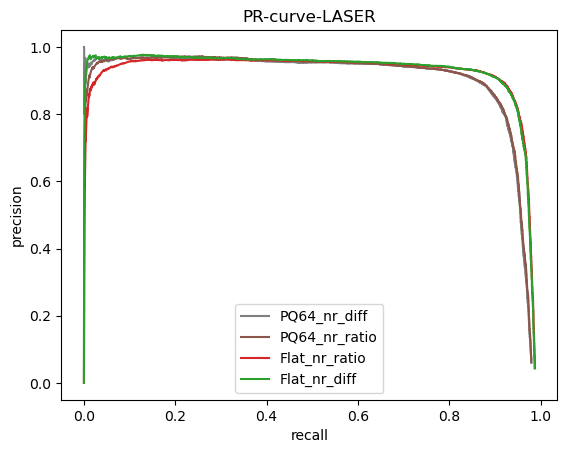

In [20]:
import matplotlib.pyplot as plt
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
#plt.plot(recalls_pq64_diff, precisions_pq64_diff, "-", markersize=10, color=colors[6],label="PQ64_diff")
plt.plot(recalls_pq64_diff_nr, precisions_pq64_diff_nr, "-", markersize=10, color=colors[7],label="PQ64_nr_diff")
#plt.plot(recalls_pq64, precisions_pq64, "-", markersize=10, color=colors[0],label="PQ64_ratio")
plt.plot(recalls_pq64_nr, precisions_pq64_nr, "-", markersize=10, color=colors[5],label="PQ64_nr_ratio")
#plt.plot(recalls_flat, precisions_flat, "-", markersize=10, color=colors[1],label="Flat_ratio")
plt.plot(recalls_flat_nr, precisions_flat_nr, "-", markersize=10, color=colors[3],label="Flat_nr_ratio")
plt.plot(recalls_flat_diff_nr, precisions_flat_diff_nr, "-", markersize=10, color=colors[2],label="Flat_nr_diff")
#plt.plot(recalls_flat_diff, precisions_flat_diff, "-", markersize=10, color=colors[4],label="Flat_diff")
plt.xlabel("recall")
plt.ylabel("precision")
#plt.xscale("log")
#plt.yscale("log")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("PR-curve-LASER")
plt.legend()
plt.show()

In [16]:
import faiss
import numpy as np
#debug only
with open('/checkpoint/marialomeli/bucc_evaluation/bucc2018.fr-en.train.txt.en', 'r') as f:
    text = f.readlines()

In [13]:
d = 1024
nt = 100_000
xb = np.fromfile('/private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.fr-en.train.en', np.float16)
xb.resize(xb.shape[0] // d, d)
xb = xb.astype(np.float32)
faiss.normalize_L2(xb)
xt = np.unique(xb[:nt], axis=0) #†rain the deduper
xt.shape

(99651, 1024)

In [14]:
#debug only
index = faiss.index_factory(d, 'Flat')
index.add(xb)
_, I = index.search(xb[40727:40728], 5)
I

array([[ 40727, 208110,  40736, 208119,  40698]])

In [19]:
print(text[40727])
print(text[208110])  # note duplicate

The banana companies continued to expand, the government's budgetary situation improved, and there was even an increase in labor organizing.

The banana companies continued to expand, the government's budgetary situation improved, and there was even an increase in labor organizing.



In [20]:
deduper = faiss.index_factory(d, 'OPQ32,PQ32')
deduper.train(xt)
codes = deduper.sa_encode(xb)
codes.shape[0]  # before dedupe
369810
_, idxs, invs, cnts = np.unique(codes, axis=0, return_index=True, return_inverse=True, return_counts=True)
idxs.size  # after dedupe
368019
#debug only
for p in np.where(cnts > 1)[0]:
    for q in np.where(invs == p)[0]:
       if len(text[q]) != len(text[idxs[p]]): # print interesting matchines pairs
            print(text[idxs[p]])
            print(text[q])

Assets of Star Precision Limited, registered in BVI May 21, 1997, were reported as"cash as the investment portfolio.

Assets of Star Precision Limited, registered in BVI May 21, 1997 were reported as"cash as the investment portfolio.

The location of UNFCCC talks are rotated by regions throughout United Nations countries.

The location of UNFCCC talks is rotated by regions throughout United Nations countries.

From 1991 until 2003 the effects of government policy and sanctions regime led to hyperinflation, widespread poverty and malnutrition.

From 1991 until 2003, the effects of government policy and sanctions regime led to hyperinflation, widespread poverty and malnutrition.

Among the foreign nationals detained, imprisoned and expelled is Iyad El-Baghdadi, a popular blogger and Twitter personality.

Amongst the foreign nationals detained, imprisoned and expelled is Iyad El-Baghdadi, a popular blogger and Twitter personality.

Jackson has also been a longtime political consultant thr

In [23]:
print(codes)
idxs

array([[140, 143,  54, ..., 247, 142, 136],
       [161,  31, 117, ..., 105,  15, 152],
       [230, 189, 246, ...,  60,  61,  74],
       ...,
       [127, 128, 111, ..., 181, 209, 149],
       [119, 132, 105, ...,  20, 214, 188],
       [ 87,   2, 106, ..., 198, 247, 130]], dtype=uint8)

In [22]:
index = faiss.index_factory(d, 'Flat,IDMap')  # must use IDMap, flat indices don't support add_with_ids
index.add_with_ids(xb[idxs], idxs)
_, I = index.search(xb[40727:40728], 5)
print(I)

print(text[40727])
print(text[40736]) # nearest neighbor, note that 208110 was remove

[[ 40727  40736  40698 309969 208151]]
The banana companies continued to expand, the government's budgetary situation improved, and there was even an increase in labor organizing.

Banana exports, then accounting for 80 percent of all exports, continued to expand.

